## Getting ready
Import important modules and dataset

In [1]:
import tensorflow as tf 
#import tensorflow.compat.v1 as tf # For running intel GPU xD 
import matplotlib.pyplot as plt
import numpy as np
import random

data_raw = tf.keras.datasets.cifar10

Seperate data into testing & training data

In [2]:
(x_train, y_train), (x_test, y_test) = data_raw.load_data()

Modify the labels to reflect the expected outcome (either car or not a car)

In [3]:
class_names = ['Not a car', 'Automobile/Car']

for i in range(y_train.shape[0]):
    if y_train[i][0] not in {1, 9}:
        y_train[i][0] = 0
    else:
        y_train[i][0] = 1
        
for i in range(y_test.shape[0]):
    if y_test[i][0] not in {1, 9}:
        y_test[i][0] = 0
    else:
        y_test[i][0] = 1

## Normalize the data
This scales the color values of each pixel, which is more appropriate than standardizing.

In [4]:
x_train_min = np.min(x_train)
x_train_max = np.max(x_train)

import pickle
import_car_train_images = open("train.pkl", "rb")

car_images = pickle.load(import_car_train_images)
car_labels = np.empty([8144, 1])
for i in range(8144):
    car_labels[i][0] = 1

In [5]:
x_train = np.concatenate((x_train, car_images))
y_train = np.concatenate((y_train, car_labels))

x_train, x_test = x_train / 255.0, x_test / 255.0
x_train_normal = (x_train - x_train_min) / (x_train_max - x_train_min)
x_test_normal = (x_test - x_train_min) / (x_train_max - x_train_min)

'Flatten' the images so they are represented by a 1d array
* This is only used for some models

In [6]:
x_train_flat = x_train_normal.reshape(x_train_normal.shape[0], -1)
x_test_flat = x_test_normal.reshape(x_test_normal.shape[0], -1)

# Building the Models
Models are generated from classes so it's easier to tweak parameters later and manage variable names

In [7]:
from tensorflow.keras import models, layers
from tensorflow.keras.optimizers import Adam
from functools import partial

class UniformDeepDense:
    def __init__(self):
        self.model = models.Sequential(name="Normal")
        self.activation = 'relu'
        self.train_epochs = 40 # Diminishing returns past 10 epochs
        self.shape = (3072, ) # 32 x 32 x 3 (flattened)
        self.optimizer = Adam()
        self.generateLayers()
        self.compileModel()
    def generateLayers(self):
        self.model.add(layers.Dense(512, activation=self.activation, input_shape=self.shape))
        self.model.add(layers.Dense(256, activation=self.activation))
        self.model.add(layers.Dense(128, activation=self.activation))
        self.model.add(layers.Dense(2, activation='softmax'))
    def compileModel(self):
        self.model.compile(optimizer=self.optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    def train(self, x_train, y_train, x_test, y_test):
        self.history = self.model.fit(x_train, y_train, epochs=self.train_epochs, validation_data=(x_test, y_test))
        self.loss, self.accuracy = self.model.evaluate(x_test, y_test)
        
class ConvNN:
    def __init__(self):
        self.model = models.Sequential(name="Convolutional")
        self.shape=[32, 32, 3] # Conv2D needs list
        self.epochs = 40
        self.optimizer = Adam()
        self.default_layer = partial(layers.Conv2D, kernel_size=6,
                                    padding='same', activation='relu',
                                    kernel_initializer='he_normal')
        self.generateLayers()
        self.compile_model()
    def generateLayers(self):
        self.model.add(self.default_layer(filters=64, kernel_size=10, input_shape=self.shape))
        self.model.add(layers.MaxPool2D())
        self.model.add(self.default_layer(filters=128))
        self.model.add(layers.MaxPool2D())
        #self.model.add(self.default_layer(filters=256))
        #self.model.add(layers.MaxPool2D())
        #self.model.add(self.default_layer(filters=512))
        #self.model.add(layers.MaxPool2D())
        self.model.add(layers.Flatten())
        self.model.add(layers.Dense(units=128, activation='relu', kernel_initializer='he_normal'))
        self.model.add(layers.Dropout(0.5))
        self.model.add(layers.Dense(units=2, activation='softmax'))
    def compile_model(self):
        self.model.compile(optimizer=self.optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    def train(self, x_train, y_train, x_test, y_test):
        self.history = self.model.fit(x_train, y_train, epochs=self.epochs, validation_data=(x_test, y_test))
        self.loss, self.accuracy = self.model.evaluate(x_test, y_test)
        


# Testing the models

In [24]:
normal_NN = UniformDeepDense()
normal_NN.train_epochs = 2
normal_NN.train(x_train_flat, y_train, x_test_flat, y_test)


conv_NN = ConvNN()
conv_NN.epochs = 2
conv_NN.train(x_train, y_train, x_test, y_test)


print(f"Normal NN loss: {normal_NN.loss}")
print(f"Normal NN Accuracy: {normal_NN.accuracy}")

print(f"Convolutional NN loss: {conv_NN.loss}")
print(f"Convolutional NN Accuracy: {conv_NN.accuracy}")

c:\Users\anrme\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/2
1817/1817 ━━━━━━━━━━━━━━━━━━━━ 30s 16ms/step - accuracy: 0.7768 - loss: 0.4793 - val_accuracy: 0.8597 - val_loss: 0.3503
Epoch 2/2
1817/1817 ━━━━━━━━━━━━━━━━━━━━ 29s 16ms/step - accuracy: 0.8320 - loss: 0.3896 - val_accuracy: 0.8647 - val_loss: 0.3214
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8648 - loss: 0.3199


c:\Users\anrme\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/2
1817/1817 ━━━━━━━━━━━━━━━━━━━━ 125s 68ms/step - accuracy: 0.8425 - loss: 0.3924 - val_accuracy: 0.9185 - val_loss: 0.2056
Epoch 2/2
1817/1817 ━━━━━━━━━━━━━━━━━━━━ 126s 69ms/step - accuracy: 0.9136 - loss: 0.2241 - val_accuracy: 0.9314 - val_loss: 0.1852
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.9321 - loss: 0.1820
Normal NN loss: 0.3213738799095154
Normal NN Accuracy: 0.8647000193595886
Convolutional NN loss: 0.18523336946964264
Convolutional NN Accuracy: 0.9314000010490417


# Accuracy Testing

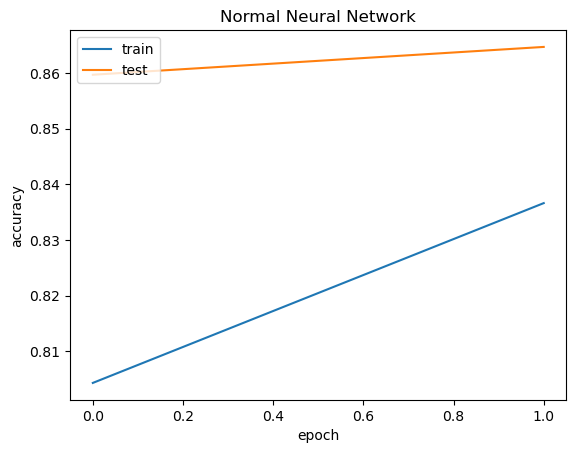

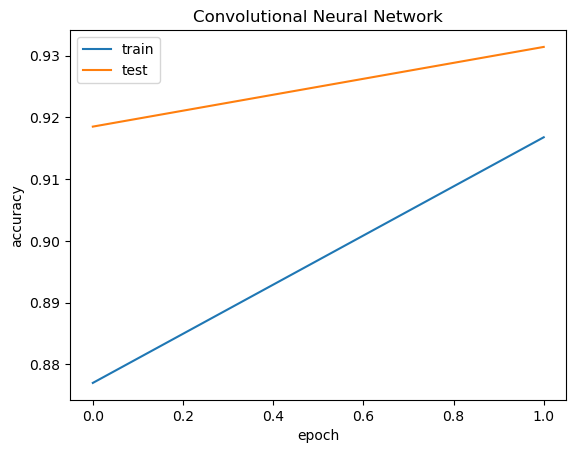

In [25]:
plt.plot(normal_NN.history.history['accuracy'])
plt.plot(normal_NN.history.history['val_accuracy'])
plt.title('Normal Neural Network')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(conv_NN.history.history['accuracy'])
plt.plot(conv_NN.history.history['val_accuracy'])
plt.title('Convolutional Neural Network')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [33]:
import pickle
images = open("output.pkl", "rb")

dev_images = pickle.load(images)

images.close()

# Normalize pixel values
dev_images = dev_images / 255.0
dev_images_flat = dev_images.reshape(dev_images.shape[0], -1)

dev_pred_label = normal_NN.model.predict(dev_images_flat)
dev_pred_label = np.argmax(dev_pred_label, axis=1)
dev_pred_label_cnn = conv_NN.model.predict(dev_images)
dev_pred_label_cnn = np.argmax(dev_pred_label_cnn, axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


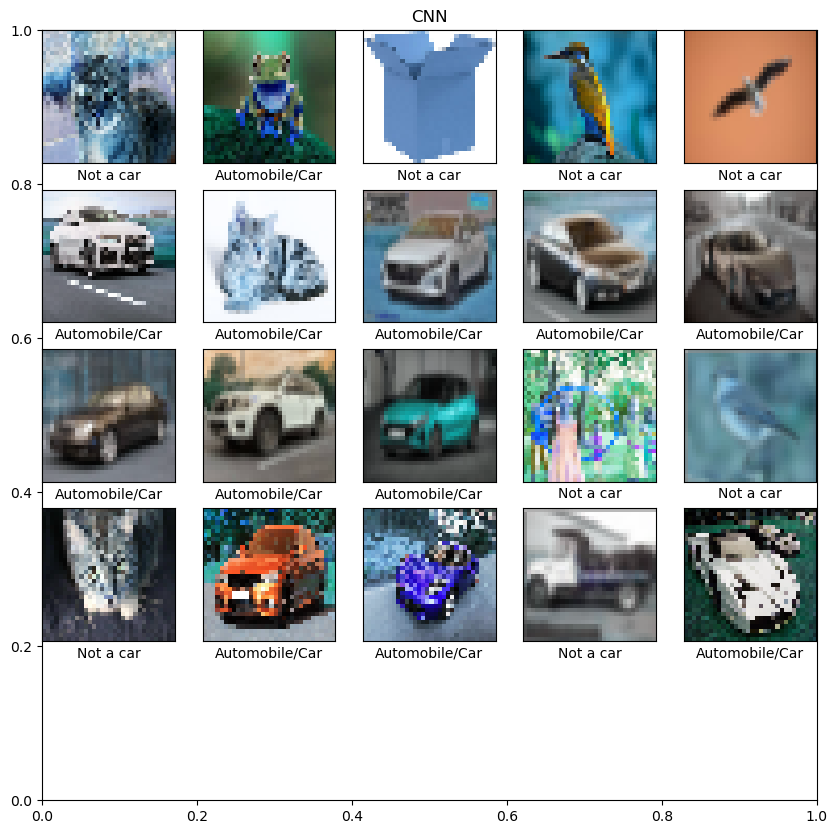

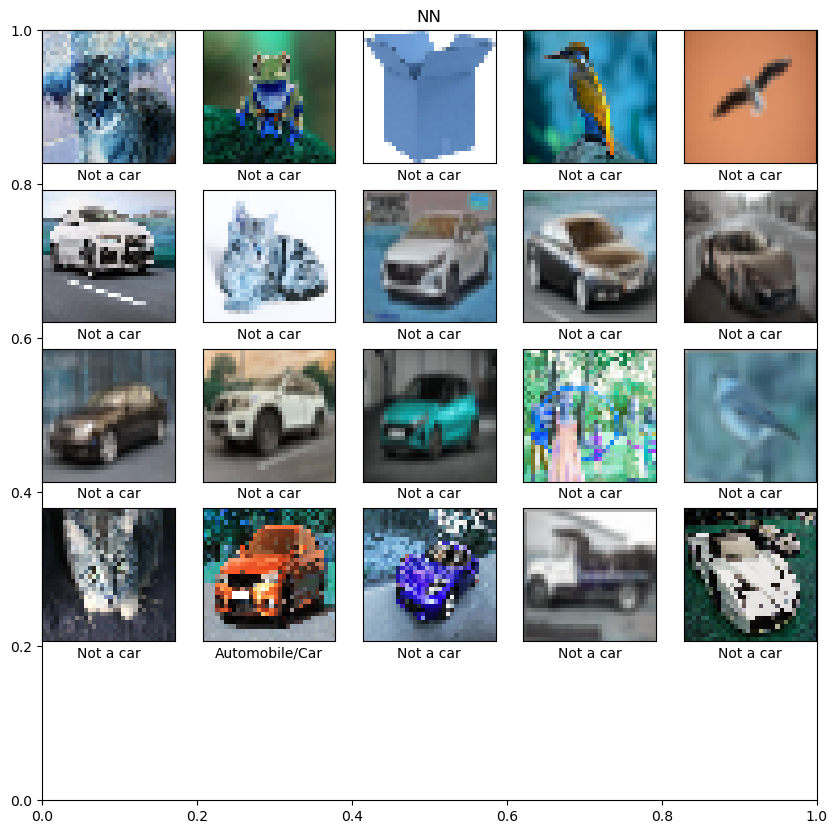

In [36]:
plt.figure(figsize=(10,10))
plt.title("CNN")
for i in range(20):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(dev_images[i].reshape(32, 32, 3))  # Reshape images to (32, 32, 3)
    choice = class_names[dev_pred_label_cnn[i]]
    plt.xlabel(choice)  # Use predicted labels from dev_pred_label
plt.show()

plt.figure(figsize=(10,10))
plt.title("NN")
for i in range(20):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(dev_images[i].reshape(32, 32, 3))  # Reshape images to (32, 32, 3)
    choice = class_names[dev_pred_label[i]]
    plt.xlabel(choice)  # Use predicted labels from dev_pred_label
plt.show()